<a href="https://colab.research.google.com/github/Dhanush-adk/intro_to_dl/blob/main/Assignment_2/Assignment_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from tqdm.notebook import tqdm
import seaborn as sns
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:05<00:00, 29437341.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [6]:
first_image, label = cifar10[0]
print(first_image.shape)

torch.Size([3, 32, 32])


In [7]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

In [8]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [9]:
def train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs = 20):
    if not train_loader or not test_loader:
        print("Empty data loaders. Exiting.")
        return None

    def calculate_metrics(predictions, targets):
        accuracy = 100 * sum([p == t for p, t in zip(predictions, targets)]) / len(targets)
        precision = precision_score(targets, predictions, average='weighted')
        recall = recall_score(targets, predictions, average='weighted')
        f1 = f1_score(targets, predictions, average='weighted')
        return accuracy, precision, recall, f1

    model.to(device)

    train_loss_list, val_loss_list, val_accuracy_list = [], [], []

    # Training loop
    epochs = n_epochs
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_list.append(running_loss / len(train_loader))

        # Validation loop
        running_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        all_predictions, all_targets = [], []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predictions.extend(predicted.tolist())
                all_targets.extend(labels.tolist())

        val_loss_list.append(running_loss / len(test_loader))
        val_accuracy = 100 * correct / total
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Final evaluation
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader, 0):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.tolist())
            all_targets.extend(targets.tolist())

    accuracy, precision, recall, f1 = calculate_metrics(all_predictions, all_targets)

    # Print the metrics
    print(f'\nFinal Evaluation Metrics:')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Return metrics
    return {
        'train_loss': train_loss_list,
        'val_loss': val_loss_list,
        'val_accuracy': val_accuracy_list,
        'final_accuracy': accuracy,
        'final_precision': precision,
        'final_recall': recall,
        'final_f1': f1,
        'all_targets': all_targets,
        'all_predictions': all_predictions,
        'model': model
    }

In [34]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, dropout_rate, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_rate):
        layers = [block(self.in_channels, out_channels, stride, dropout_rate=dropout_rate)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x


In [11]:
model_without_dropout = ResNet18(BasicBlock, [2, 2, 2, 2], 0, num_classes=10)  # 4 blocks with 2 layer each
model_without_dropout.to(device)
print(model_without_dropout)

ResNet11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [12]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
os.chdir('/content/drive/MyDrive/ADKs_files')

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_without_dropout.parameters(), lr=0.01)

In [17]:
model_without_dropout_metrics = train_and_evaluate_model(model_without_dropout, criterion, optimizer, train_loader, test_loader, device, n_epochs=20)

Epoch 1, Training loss: 1.2787, Validation loss: 1.0940, Validation Accuracy: 60.57%
Epoch 2, Training loss: 0.7755, Validation loss: 0.7979, Validation Accuracy: 72.12%
Epoch 3, Training loss: 0.5517, Validation loss: 0.6942, Validation Accuracy: 75.96%
Epoch 4, Training loss: 0.3845, Validation loss: 0.8492, Validation Accuracy: 74.15%
Epoch 5, Training loss: 0.2535, Validation loss: 0.7439, Validation Accuracy: 77.88%
Epoch 6, Training loss: 0.1629, Validation loss: 1.1040, Validation Accuracy: 73.72%
Epoch 7, Training loss: 0.1077, Validation loss: 0.8024, Validation Accuracy: 77.96%
Epoch 8, Training loss: 0.0751, Validation loss: 0.8247, Validation Accuracy: 79.17%
Epoch 9, Training loss: 0.0487, Validation loss: 1.0809, Validation Accuracy: 76.03%
Epoch 10, Training loss: 0.0415, Validation loss: 0.8612, Validation Accuracy: 79.24%
Epoch 11, Training loss: 0.0313, Validation loss: 0.8489, Validation Accuracy: 80.68%
Epoch 12, Training loss: 0.0260, Validation loss: 1.0780, Valid

In [18]:
torch.save(model_without_dropout_metrics['model'].state_dict(), 'resnetmodel_without_dropout.pth')

<Figure size 1000x800 with 0 Axes>

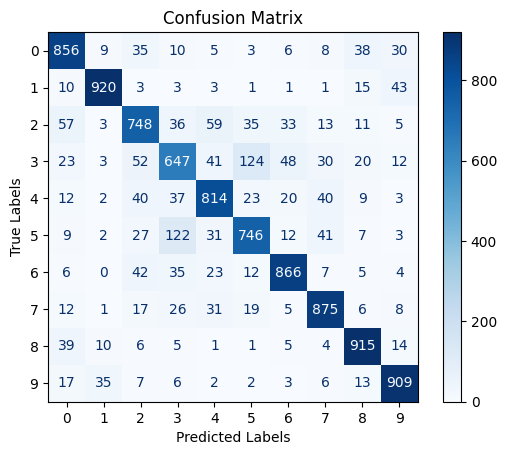

In [19]:
cm = confusion_matrix(model_without_dropout_metrics['all_targets'], model_without_dropout_metrics['all_predictions'])
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [20]:
total_params = sum(p.numel() for p in model_without_dropout_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 11173962


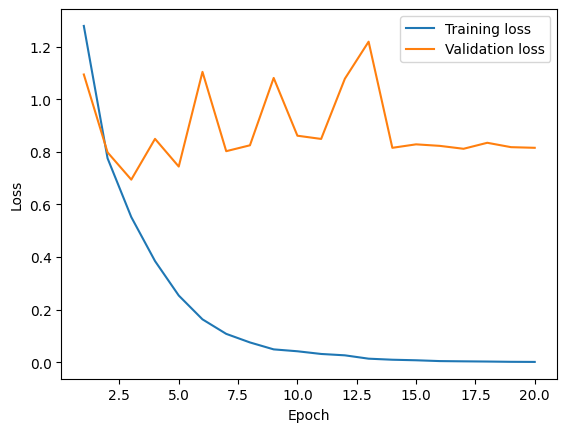

In [21]:
epochs_list = [i for i in range(1, 20+1, 1)]
plt.plot(epochs_list, model_without_dropout_metrics['train_loss'], label='Training loss')
plt.plot(epochs_list, model_without_dropout_metrics['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Resnet with dropout

In [36]:
model_with_dropout = ResNet18(BasicBlock, [2, 2, 2, 2], 0.5, num_classes=10)  # 4 blocks with 2 layer each
model_with_dropout.to(device)
print(model_with_dropout)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2):

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_with_dropout.parameters(), lr=0.01)

In [38]:
model_with_dropout_metrics = train_and_evaluate_model(model_with_dropout, criterion, optimizer, train_loader, test_loader, device, n_epochs=20)

Epoch 1, Training loss: 1.6540, Validation loss: 1.5222, Validation Accuracy: 47.98%
Epoch 2, Training loss: 1.2445, Validation loss: 1.2356, Validation Accuracy: 58.50%
Epoch 3, Training loss: 1.0385, Validation loss: 1.0503, Validation Accuracy: 64.61%
Epoch 4, Training loss: 0.9070, Validation loss: 1.1598, Validation Accuracy: 61.55%
Epoch 5, Training loss: 0.8084, Validation loss: 0.7996, Validation Accuracy: 72.55%
Epoch 6, Training loss: 0.7268, Validation loss: 0.6551, Validation Accuracy: 77.21%
Epoch 7, Training loss: 0.6653, Validation loss: 0.7145, Validation Accuracy: 75.47%
Epoch 8, Training loss: 0.6117, Validation loss: 0.5954, Validation Accuracy: 80.00%
Epoch 9, Training loss: 0.5704, Validation loss: 0.5994, Validation Accuracy: 80.09%
Epoch 10, Training loss: 0.5357, Validation loss: 0.5572, Validation Accuracy: 81.69%
Epoch 11, Training loss: 0.4923, Validation loss: 0.5079, Validation Accuracy: 83.02%
Epoch 12, Training loss: 0.4708, Validation loss: 0.5740, Valid

In [39]:
torch.save(model_with_dropout_metrics['model'].state_dict(), 'resnetmodel_with_dropout.pth')

<Figure size 1000x800 with 0 Axes>

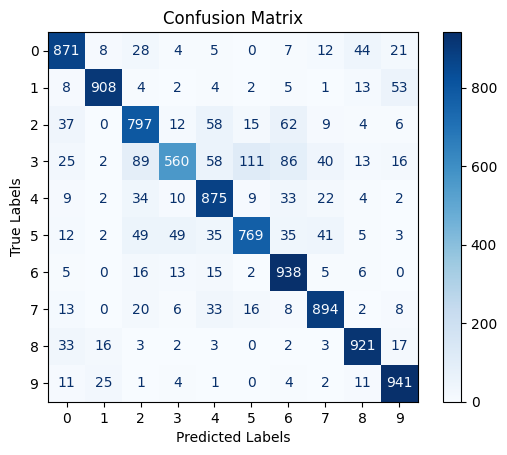

In [40]:
cm = confusion_matrix(model_with_dropout_metrics['all_targets'], model_with_dropout_metrics['all_predictions'])
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [41]:
total_params = sum(p.numel() for p in model_with_dropout_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 11173962


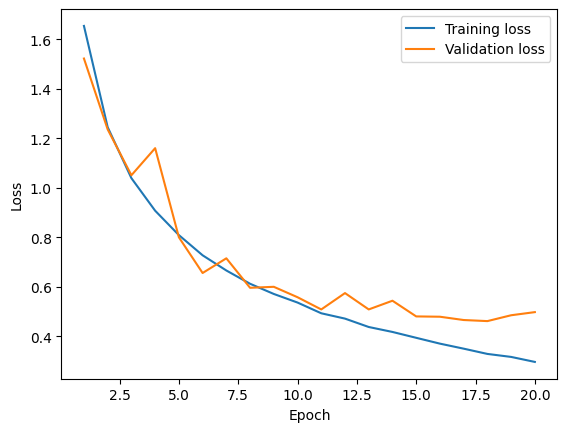

In [42]:
epochs_list = [i for i in range(1, 20+1, 1)]
plt.plot(epochs_list, model_with_dropout_metrics['train_loss'], label='Training loss')
plt.plot(epochs_list, model_with_dropout_metrics['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()